# Data Analysis - Travel Destinations

In this notebook, we explore and construct a travel destination model: each travel destination is given different features in order to help the customer make a travel plan suitable to their likings.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Obtaining a list of popular destinations
First we need a list of destinations. We choose the list of destinations of the 5 most popular airlines in the UK - British Airways (BA), EasyJet, Ryanair, Emirates and Etihad Airways. This data is public and can be retrived from Wikipedia: 

British Airways:
https://en.wikipedia.org/wiki/List_of_British_Airways_destinations,

Easyjet:
https://en.wikipedia.org/wiki/List_of_EasyJet_destinations,

Ryanair:
https://en.wikipedia.org/wiki/List_of_Ryanair_destinations,

Emirates:
https://en.wikipedia.org/wiki/List_of_Emirates_destinations,

Etihad Airways
https://en.wikipedia.org/wiki/List_of_Etihad_Airways_destinations.

In [3]:
# loading destinations datasets
ba_destinations = pd.read_csv('./travel_destinations_data/ba_destinations.csv')
ej_destinations = pd.read_csv('./travel_destinations_data/easyjet_destinations.csv')
ra_destinations = pd.read_csv('./travel_destinations_data/ryanair_destinations.csv')
em_destinations = pd.read_csv('./travel_destinations_data/em_destinations.csv')
et_destinations = pd.read_csv('./travel_destinations_data/et_destinations.csv')

In [4]:
# we drop all destinations that has been terminated (note: easyjet destinations excludes terminated)
ba_destinations.drop(index=ba_destinations[ba_destinations['Notes'] == 'Terminated'].index, inplace=True)
ra_destinations.drop(index=ra_destinations[ra_destinations['Notes'] == 'Terminated'].index, inplace=True)
em_destinations.drop(index=em_destinations[em_destinations['Notes'] == 'Terminated'].index, inplace=True)
et_destinations.drop(index=et_destinations[et_destinations['Notes'] == 'Terminated'].index, inplace=True)
ba_destinations.reset_index(drop=True)
ra_destinations.reset_index(drop=True)
em_destinations.reset_index(drop=True)
et_destinations.reset_index(drop=True)

# create a list of all countries and cities from the five airlines
all_destinations = []
for i in range(ba_destinations.shape[0]):
    all_destinations.append([
        ba_destinations.iloc[i]['Country'],
        ba_destinations.iloc[i]['City']
    ])

for i in range(ej_destinations.shape[0]):
    destination = [ej_destinations.iloc[i]['Country'], ej_destinations.iloc[i]['City']]
    if destination not in all_destinations:
        all_destinations.append(destination)
    else:
        continue

for i in range(ra_destinations.shape[0]):
    destination = [ra_destinations.iloc[i]['Country'], ra_destinations.iloc[i]['City']]
    if destination not in all_destinations:
        all_destinations.append(destination)
    else:
        continue
        
for i in range(em_destinations.shape[0]):
    destination = [em_destinations.iloc[i]['Country'], em_destinations.iloc[i]['City']]
    if destination not in all_destinations:
        all_destinations.append(destination)
    else:
        continue
        
for i in range(et_destinations.shape[0]):
    destination = [et_destinations.iloc[i]['Country'], et_destinations.iloc[i]['City']]
    if destination not in all_destinations:
        all_destinations.append(destination)
    else:
        continue

number_of_destinations = len(all_destinations)
print(f'Number of destinationas: {number_of_destinations}')

# converting our list of destinations into a dataframe
dest_df = pd.DataFrame(all_destinations)
dest_df.columns=['Country','City']
pd.set_option('display.max_rows', number_of_destinations)
dest_df.sort_values(by=['Country', 'City'], ascending=[True, True], inplace=True)
dest_df.reset_index(inplace=True)
dest_df.drop(columns='index', inplace=True)
dest_df.head(5)

Number of destinationas: 429


,Country,City
0,Afghanistan,Kabul
1,Albania,Tirana
2,Algeria,Algiers
3,Angola,Luanda
4,Antigua and Barbuda,St. John's


One important factor to take into account when recommanding travel plan is how far the destination is. This also affect flight prices and budget. Here we add the co-ordinates of each city using open data from World Cities Database: https://simplemaps.com/data/world-cities. 

In [5]:
# loading world cities coordinates database
coords_data = pd.read_csv('./travel_destinations_data/worldcities.csv')
coords_data.reset_index(inplace=True)
all_destinations = dest_df.values.tolist()
all_cities_coords=[]
# adding coordinates by iterating through the list
for country, city in all_destinations:
    filt = (coords_data['city_ascii'] == city) & (coords_data['country'] == country)
    series = coords_data.loc[filt]
    series.reset_index(inplace=True)
    try:
        # note: store location data as string
        city_coords = str(series.loc[0, 'lat']) + ', ' + str(series.loc[0, 'lng'])
    except KeyError:
        city_coords = 'unknown'
    all_cities_coords.append(city_coords)
dest_df['Location'] = all_cities_coords
# delete all rows with unknown coordinates
# these places are not popular enough to be on our list of destinations!
dest_df = dest_df[dest_df.Location != 'unknown']
# dest_df.reset_index(inplace=True)
# dest_df.drop(columns='index', inplace=True)
dest_df

,Country,City,Location
0,Afghanistan,Kabul,"34.5167, 69.1833"
1,Albania,Tirana,"41.3275, 19.8189"
2,Algeria,Algiers,"36.7631, 3.0506"
3,Angola,Luanda,"-8.8383, 13.2344"
4,Antigua and Barbuda,St. John's,"17.118, -61.85"
5,Argentina,Buenos Aires,"-34.6025, -58.3975"
6,Armenia,Gyumri,"40.7894, 43.8475"
7,Armenia,Yerevan,"40.1812, 44.5136"
8,Australia,Brisbane,"-27.455, 153.0351"
9,Australia,Melbourne,"-37.82, 144.975"


## Plotting Travel Destinations on a World Map

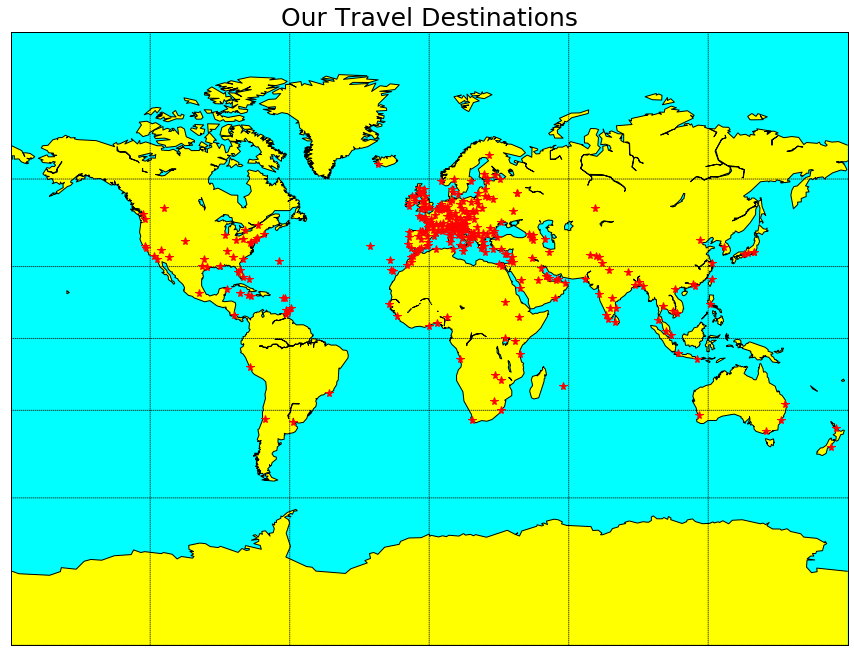

In [85]:
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(15, 20))
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='yellow',lake_color='aqua')
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')
plt.title("Our Travel Destinations", size=25)
dest_to_plot = dest_df.values.tolist()
for i in dest_to_plot:
    lat, lng = i[2].split(', ')
    x, y = m(float(lng), float(lat))  # idk why but Basemap takes in latitude first
    m.plot(x, y, '*', color='red', markersize=8)
plt.show()

## Adding features to the destinations
There are many things people consider when choosing a holiday destination. One of the most important factor people consider is cost.
### Measuring cost
We use cost-of-living index to assign each destination with a 'Cost' feature value. This index was developed by Russian economist A. A. Konüs and measures differences in the price of goods and services, and allows for substitutions with other items as prices vary. (Source: Wikipedia)
As different cities in a country has slightly different cost-of-living, we first try to assign the'Cost' feature using the cost-of-living index of indicidual city, then we fill the unassigned destination with the cost-of-living index of their respective country. It is worth noting that the calculation of the index is done in the same way in cities or countries hence they are comparable.

In [17]:
dest_df.values.tolist()

[['Afghanistan', 'Kabul', '34.5167, 69.1833'],
 ['Albania', 'Tirana', '41.3275, 19.8189'],
 ['Algeria', 'Algiers', '36.7631, 3.0506'],
 ['Angola', 'Luanda', '-8.8383, 13.2344'],
 ['Antigua and Barbuda', "St. John's", '17.118, -61.85'],
 ['Argentina', 'Buenos Aires', '-34.6025, -58.3975'],
 ['Armenia', 'Gyumri', '40.7894, 43.8475'],
 ['Armenia', 'Yerevan', '40.1812, 44.5136'],
 ['Australia', 'Brisbane', '-27.455, 153.0351'],
 ['Australia', 'Melbourne', '-37.82, 144.975'],
 ['Australia', 'Perth', '-31.955, 115.84'],
 ['Australia', 'Sydney', '-33.92, 151.1852'],
 ['Austria', 'Graz', '47.0778, 15.41'],
 ['Austria', 'Innsbruck', '47.2804, 11.41'],
 ['Austria', 'Klagenfurt', '46.6203, 14.31'],
 ['Austria', 'Salzburg', '47.8105, 13.04'],
 ['Austria', 'Vienna', '48.2, 16.3666'],
 ['Azerbaijan', 'Baku', '40.3953, 49.8622'],
 ['Bahamas', 'Nassau', '25.0834, -77.35'],
 ['Bahrain', 'Manama', '26.2361, 50.5831'],
 ['Bangladesh', 'Chittagong', '22.33, 91.8'],
 ['Bangladesh', 'Dhaka', '23.7231, 90.40